# Bayesian Linear Regression

George Ho 9/27/17

This notebook illustrates Bayesian linear regression and Bayesian prediction. The ultimate aim was to reproduce figures 3.7 and 3.8 in Bishop's Pattern Recognition and Machine Learning (PRML).

## Sequential Bayesian Linear Regression (PRML Figure 3.7)

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import seaborn as sns
sns.set_style("white")
from itertools import chain
from numpy.core.umath_tests import inner1d
from random import shuffle

In [25]:
num_obs = 20    # Number of observations

# f(x) = (a_0) + (a_1)x + noise
a_0 = 0.3       # Intercept (ground truth)
a_1 = 0.5       # Slope (ground truth)
beta = 25       # Precision (known)
alpha = 2       # Hyperparameter

In [26]:
def linear_design(x):
    '''
    Given an observation or a list of observations,
    returns the design matrix for the 2 linear basis
    functions phi_1 = 1 and phi_2 = x
    '''
    if type(x) == np.float64:
        design = np.ones((1, 2))        
    else:
        design = np.ones((len(x), 2))
    design[:, 1] = x
    return design

In [27]:
def update(m, S, phi, t):
    '''
    Given the mean vector, covariance matrix, a design matrix and a label
    (or list of labels), returns the updated mean vector and covariance
    '''
    # Reshape t to avoid any treacherous numpy broadcasting...
    if type(t) == np.ndarray:
        t = np.reshape(t, (len(t), 1))

    S_updated = np.linalg.inv(np.linalg.inv(S)
                              + beta*np.dot(np.transpose(phi), phi))

    m_updated = np.dot(S_updated,
                       np.dot(np.linalg.inv(S), m)
                       + beta*np.dot(np.transpose(phi), t))

    return m_updated, S_updated

In [41]:
def plot_likelihood(label, obs, ax=None):
    '''
    Given an axes, a label and an observation, plots the likelihood
    via a seaborn heatmap
    '''
    if ax is None:
        ax = plt.gca()

    XX, YY = np.meshgrid(np.arange(-1, 1, 0.01),
                         np.arange(-1, 1, 0.01))
    #XX, YY = np.mgrid[-1:1:0.01, -1:1:0.01]
    likelihood = np.sqrt(beta/(2*np.pi)) \
        * np.exp((-beta/2)*(label - XX - YY*obs)**2)

    sns.heatmap(np.flipud(likelihood),
                cmap='jet',
                cbar=False,
                xticklabels=False,
                yticklabels=False,
                ax=ax)

    ax.set_xlabel('w0')
    ax.set_ylabel('w1')

    return ax

In [36]:
def plot_gaussian(mean=[0, 0], cov=[[1, 0], [0, 1]], ax=None):
    '''
    Given a mean vector, a covariance matrix and an axes, plots
    the Gaussian prior/posterior

    Modified from scipy documentation:
    docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.multivariate_normal.html
    '''
    if ax is None:
        ax = plt.gca()

    mean = list(chain(*mean.tolist()))
    cov = cov.tolist()

    XX, YY = np.mgrid[-1:1:0.01, -1:1:0.01]
    pos = np.empty(XX.shape + (2,))
    pos[:, :, 0] = XX
    pos[:, :, 1] = YY
    rv = multivariate_normal(mean, cov)
    ax.contourf(XX, YY, rv.pdf(pos), cmap='jet')
    ax.set_xlabel('w0')
    ax.set_ylabel('w1')
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)

    ax.scatter(a_0, a_1, marker='P', color='white')
    
    return ax

In [31]:
def plot_posterior_samples(m, S, x=None, t=None, ax=None):
    '''
    Given a mean vector, a covariance matrix, and optionally a list
    of observations and a list of labels, populates the data space
    with samples from the posterior, and overlays a scattergram of
    the data points, if provided
    '''
    if ax is None:
        ax = plt.gca()

    coeffs = np.random.multivariate_normal(m.flatten(), S, 6)

    foo = np.linspace(-1, 1)
    for i in range(6):
        bar = coeffs[i, 0] + coeffs[i, 1]*foo
        ax.plot(foo, bar)
        ax.set_xlabel('w0')
        ax.set_ylabel('w1')
        ax.set_xlim(-1, 1)
        ax.set_ylim(-1, 1)

    if x is not None and t is not None:
        ax.scatter(x, t)

    return ax

In [38]:
# Generate observations
x = np.random.uniform(-1, 1, num_obs)
shuffle(x)
t = a_0 + a_1*x + np.random.normal(0, np.sqrt(1/beta), num_obs)

# Prior
m0 = np.array([[0], [0]])
S0 = alpha * np.identity(2)

# Learning from 1st observation/label
m1, S1 = update(m0, S0, linear_design(x[0]), t[0])

# Learning from 2nd observation/label
m2, S2 = update(m1, S1, linear_design(x[1]), t[1])

# Learning from the rest of the data
m20, S20 = update(m2, S2, linear_design(x[1:]), t[1:])

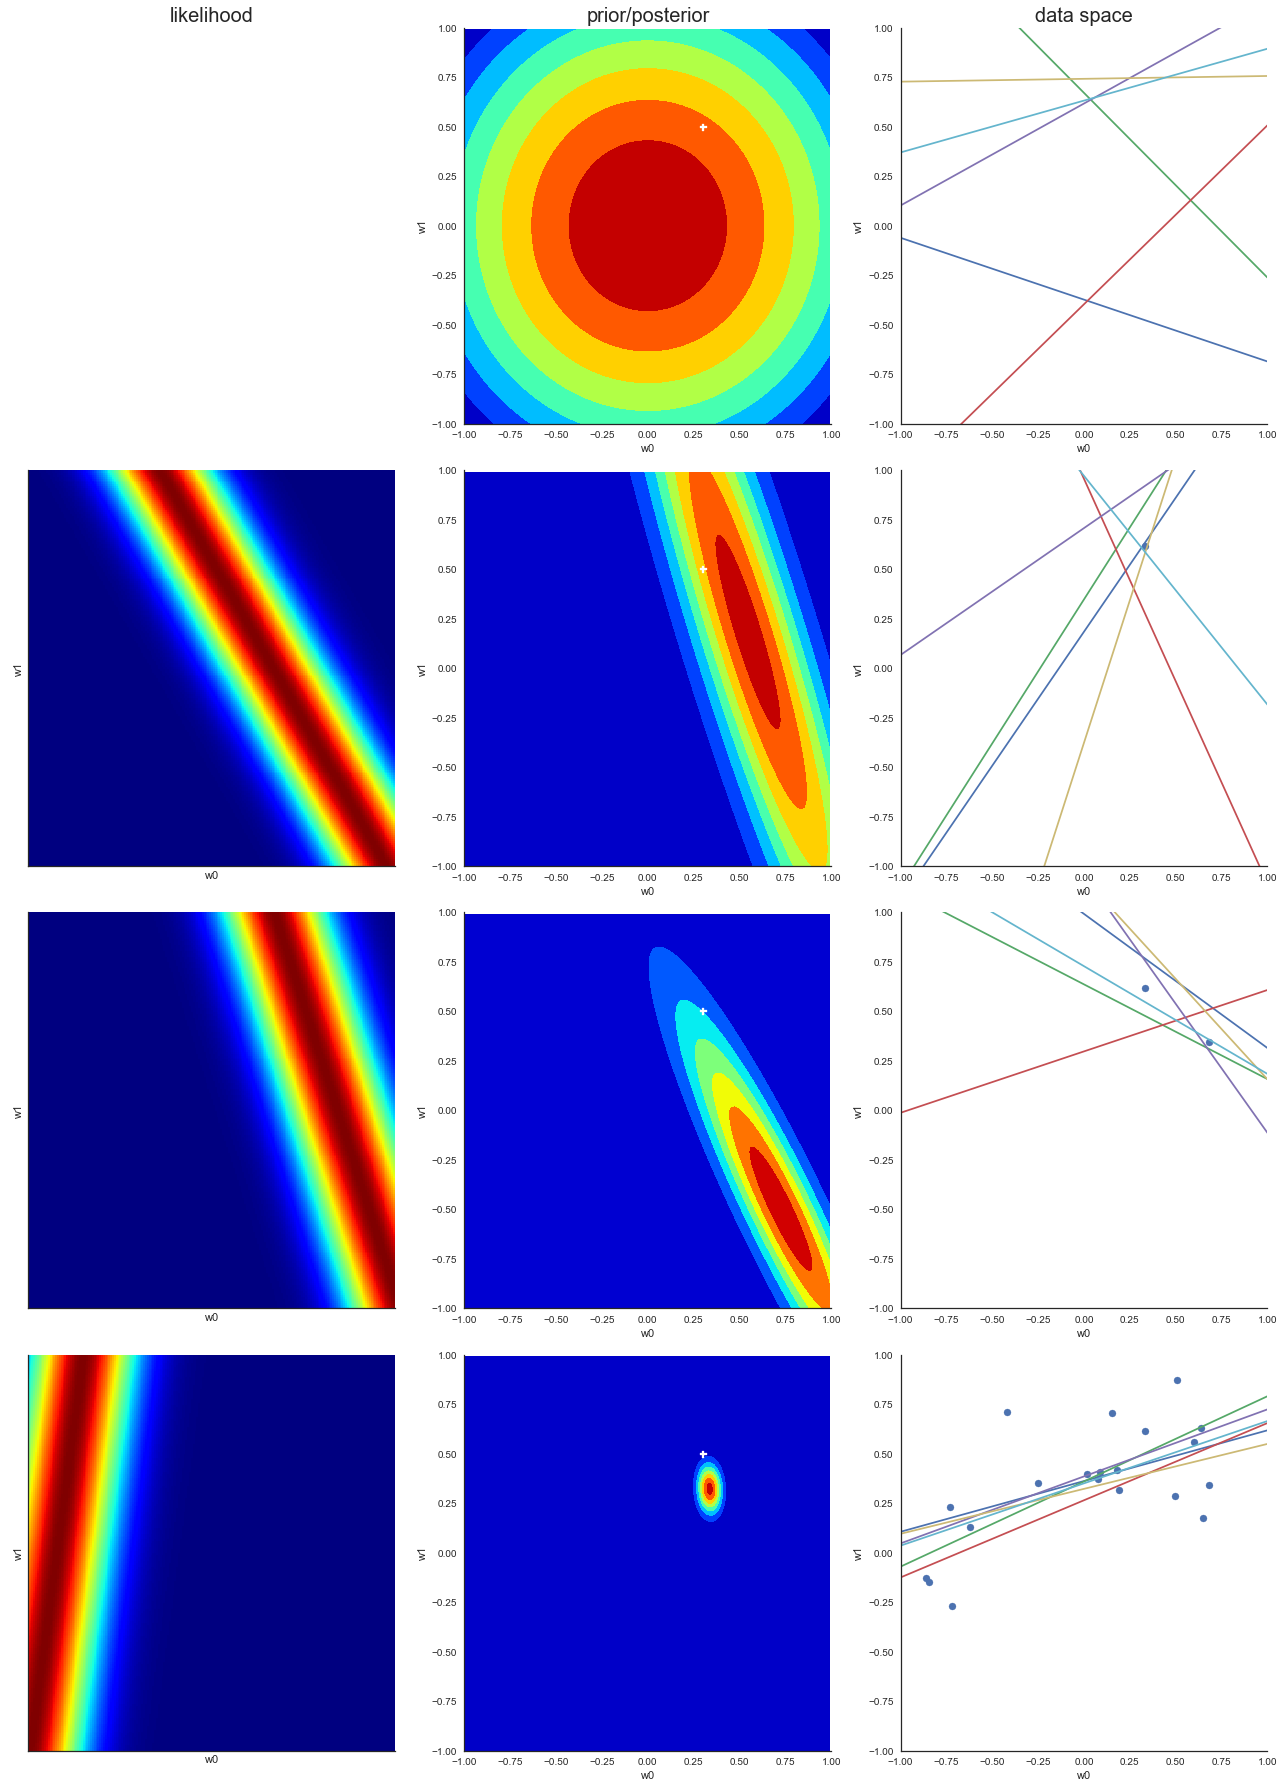

In [42]:
# Plot
fig, axarr = plt.subplots(nrows=4, ncols=3, figsize=[18, 25])

axarr[0, 0].set_title('likelihood', fontsize=20)
axarr[0, 0].axis('off')
axarr[0, 1].set_title('prior/posterior', fontsize=20)
axarr[0, 2].set_title('data space', fontsize=20)

plot_gaussian(m0, S0, axarr[0, 1])
plot_posterior_samples(m0, S0, ax=axarr[0, 2])

plot_likelihood(x[0], t[0], axarr[1, 0])
plot_gaussian(m1, S1, axarr[1, 1])
plot_posterior_samples(m1, S1, x[0], t[0], axarr[1, 2])

plot_likelihood(x[1], t[1], axarr[2, 0])
plot_gaussian(m2, S2, axarr[2, 1])
plot_posterior_samples(m2, S2, x[:2], t[:2], axarr[2, 2])

plot_likelihood(x[-1], t[-1], axarr[3, 0])
plot_gaussian(m20, S20, axarr[3, 1])
plot_posterior_samples(m20, S20, x, t, axarr[3, 2])

plt.tight_layout()
sns.despine(fig)
plt.show()

## Predictive Distribution (PRML Figure 3.8)

In [10]:
# Means of Gaussian radial basis functions
basis_means = np.linspace(0, 1, 9)

# Stdev of Gaussian radial basis functions
basis_stdev = 0.3

num_obs = 25    # Number of observations
beta = 25       # Precision (known)
alpha = 2       # Hyperparameter

In [11]:
def gaussian_design(x):
    '''
    Given an observation or a list of observations,
    returns the design matrix for the 9 Gaussian radial
    basis functions (with means basis_means and common 
    standard deviation basis_stdev)
    '''
    if type(x) == np.float64:
        design = np.zeros((1, 9))
    else:
        design = np.zeros((len(x), 9))

    for i in range(design.shape[1]):
        design[:, i] = np.exp(-(x - basis_means[i])**2
                              / (2*(basis_stdev)**2))

    return design

In [12]:
def plot_ground_truth(ax=None):
    '''
    Given an axes, plots sin(2*pi*x)
    '''
    if ax is None:
        ax = plt.gca()

    x = np.linspace(0, 1)
    t = np.sin(2*np.pi*x)
    ax.plot(x, t, color='green')
    
    return ax

In [13]:
def plot_predictive_mean(m_N, ax=None):
    '''
    Given the mean vector of the predictive distribution and an axes,
    plots the mean of the predictive distribution as a function of
    observation
    '''
    if ax is None:
        ax = plt.gca()

    x = np.linspace(0, 1)
    predictive_mean = np.transpose(np.dot(gaussian_design(x), m_N))

    ax.plot(x, predictive_mean.squeeze(), color='red')

    return ax, predictive_mean

In [14]:
def plot_predictive_stdev(S_N, predictive_mean, ax=None):
    '''
    Given the covariance matrix of the predictive distribution and the
    predictive mean as a function of observation, shades in 1 standard
    deviation above and below the predictive mean
    '''
    x = np.linspace(0, 1)
    stdev = np.sqrt(1/beta
                    + inner1d(
                        np.dot(gaussian_design(x),
                               S_N),
                        gaussian_design(x)))

    upper = predictive_mean + stdev
    lower = predictive_mean - stdev

    ax.fill_between(x,
                    upper.squeeze(),
                    lower.squeeze(),
                    facecolor='red',
                    alpha=0.3,
                    interpolate=True)
    
    return ax

In [15]:
def plot_data(num, ax=None):
    '''
    Given a number of data points to plot and an axes, plots
    the appropriate number of data points
    '''
    if ax is None:
        ax = plt.gca()

    ax.scatter(x[:num], t[:num])

    return ax

In [16]:
# Generate observations and labels
x = np.linspace(0, 1, num_obs)
shuffle(x)
t = np.sin(2*np.pi*x) + np.random.normal(0, np.sqrt(1/beta), num_obs)

# Prior
m0 = np.zeros([9, 1])
S0 = alpha * np.identity(9)

# Learning from 1st observation/label
m1, S1 = update(m0, S0, gaussian_design(x[0]), t[0])

# Learning from 2nd observation/label
m2, S2 = update(m1, S1, gaussian_design(x[1]), t[1])

# Learning from 4th observation/label
m4, S4 = update(m2, S2, gaussian_design(x[2:4]), t[2:4])

# Learning from the rest of the data
m25, S25 = update(m4, S4, gaussian_design(x[4:]), t[4:])

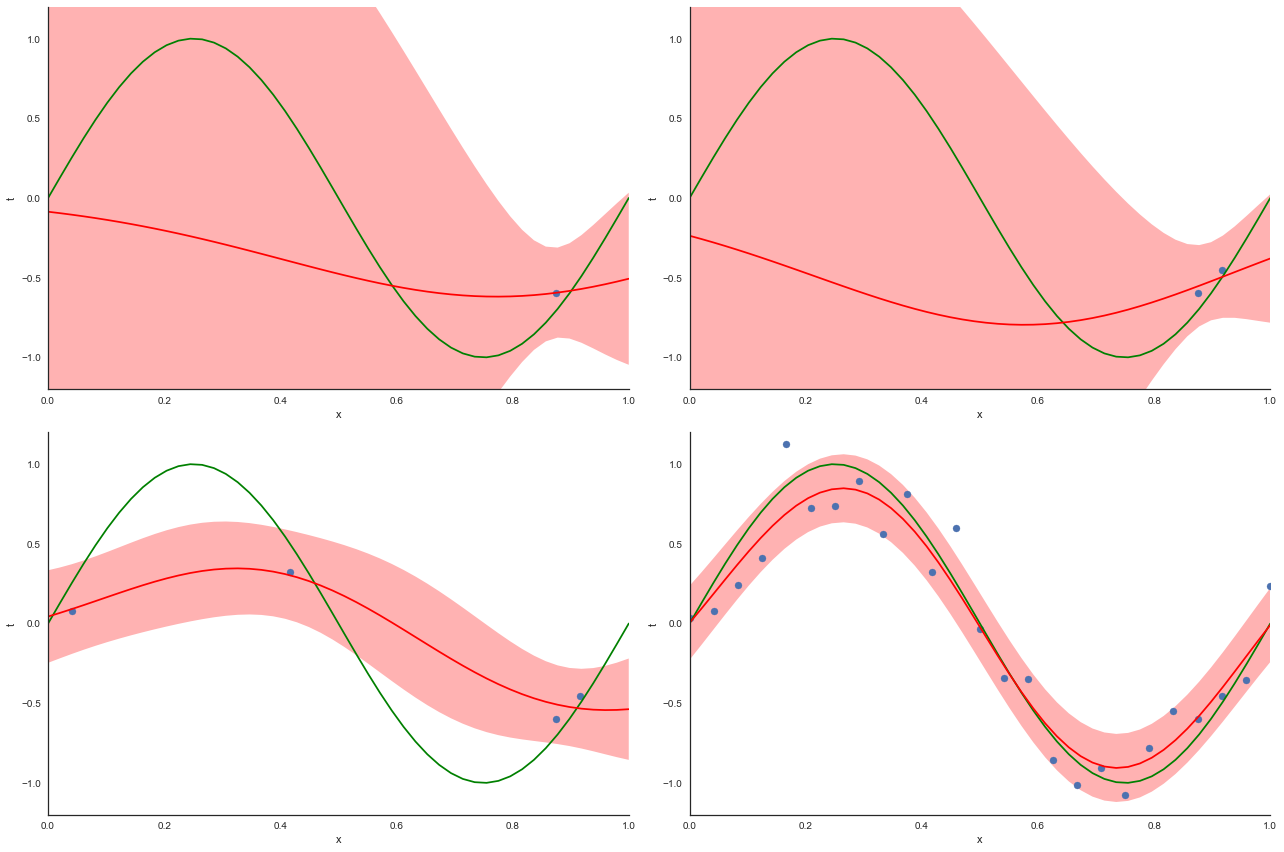

In [17]:
# Plot
fig, axarr = plt.subplots(nrows=2, ncols=2, figsize=[18, 12])

plot_ground_truth(axarr[0, 0])
_, predictive_mean = plot_predictive_mean(m1, axarr[0, 0])
plot_predictive_stdev(S1, predictive_mean, axarr[0, 0])
plot_data(1, axarr[0, 0])
axarr[0, 0].set_ylim([-1.2, 1.2])
axarr[0, 0].set_xlim([0, 1])
axarr[0, 0].set_ylabel('t')
axarr[0, 0].set_xlabel('x')

plot_ground_truth(axarr[0, 1])
_, predictive_mean = plot_predictive_mean(m2, axarr[0, 1])
plot_predictive_stdev(S2, predictive_mean, axarr[0, 1])
plot_data(2, axarr[0, 1])
axarr[0, 1].set_ylim([-1.2, 1.2])
axarr[0, 1].set_xlim([0, 1])
axarr[0, 1].set_ylabel('t')
axarr[0, 1].set_xlabel('x')

plot_ground_truth(axarr[1, 0])
_, predictive_mean = plot_predictive_mean(m4, axarr[1, 0])
plot_predictive_stdev(S4, predictive_mean, axarr[1, 0])
plot_data(4, axarr[1, 0])
axarr[1, 0].set_ylim([-1.2, 1.2])
axarr[1, 0].set_xlim([0, 1])
axarr[1, 0].set_ylabel('t')
axarr[1, 0].set_xlabel('x')

plot_ground_truth(axarr[1, 1])
_, predictive_mean = plot_predictive_mean(m25, axarr[1, 1])
plot_predictive_stdev(S25, predictive_mean, axarr[1, 1])
plot_data(25, axarr[1, 1])
axarr[1, 1].set_ylim([-1.2, 1.2])
axarr[1, 1].set_xlim([0, 1])
axarr[1, 1].set_ylabel('t')
axarr[1, 1].set_xlabel('x')

plt.tight_layout()
sns.despine()
plt.show()